>> Cosine Similarity:
16.49% >> max pairwise similarity | 15.63% >> collectively similar | Document-sample-docx-2.docx
91.75% >> max pairwise similarity | 65.81% >> collectively similar | Document-sample-docx.docx
100.00% >> max pairwise similarity | 69.41% >> collectively similar | Document-sample-pdf.pdf
100.00% >> max pairwise similarity | 69.41% >> collectively similar | Document-sample-txt.txt
>> Correlation Similarity:
-11.24% >> max pairwise similarity | -11.45% >> collectively similar | Document-sample-docx-2.docx
90.52% >> max pairwise similarity | 56.60% >> collectively similar | Document-sample-docx.docx
100.00% >> max pairwise similarity | 59.65% >> collectively similar | Document-sample-pdf.pdf
100.00% >> max pairwise similarity | 59.65% >> collectively similar | Document-sample-txt.txt
>> Jaccard Similarity:
6.13% >> max pairwise similarity | 5.79% >> collectively similar | Document-sample-docx-2.docx
63.29% >> max pairwise similarity | 43.89% >> collectively similar | Do

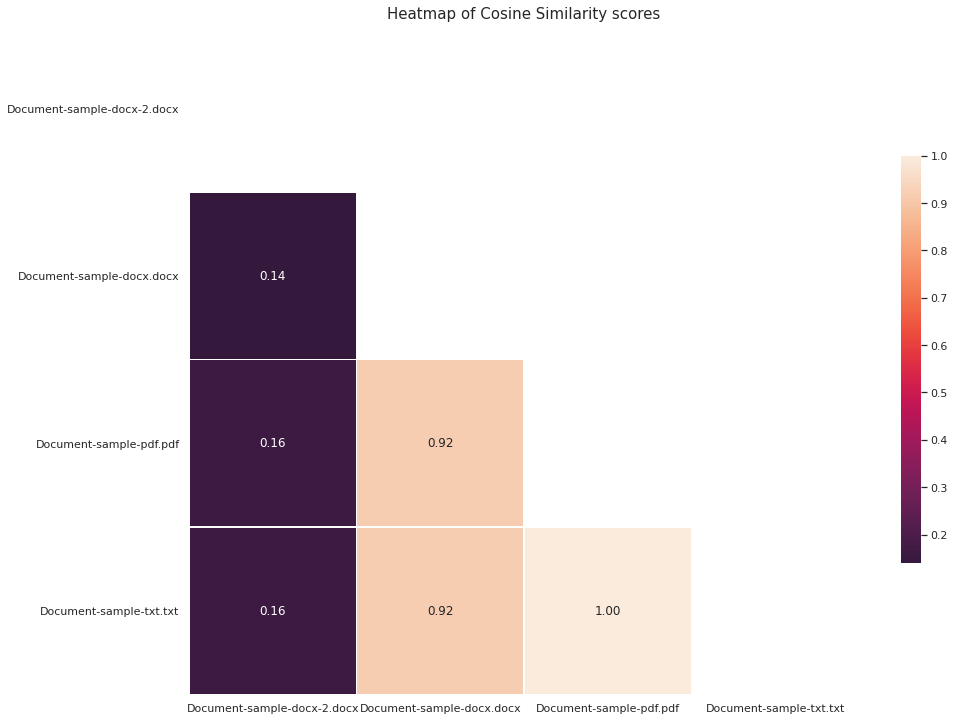

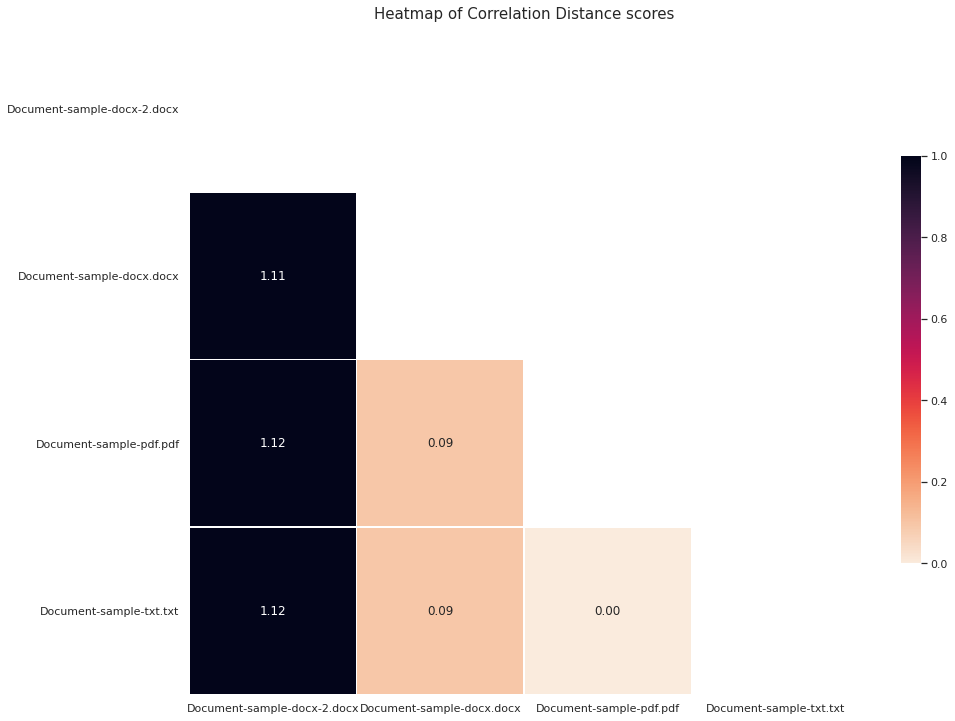

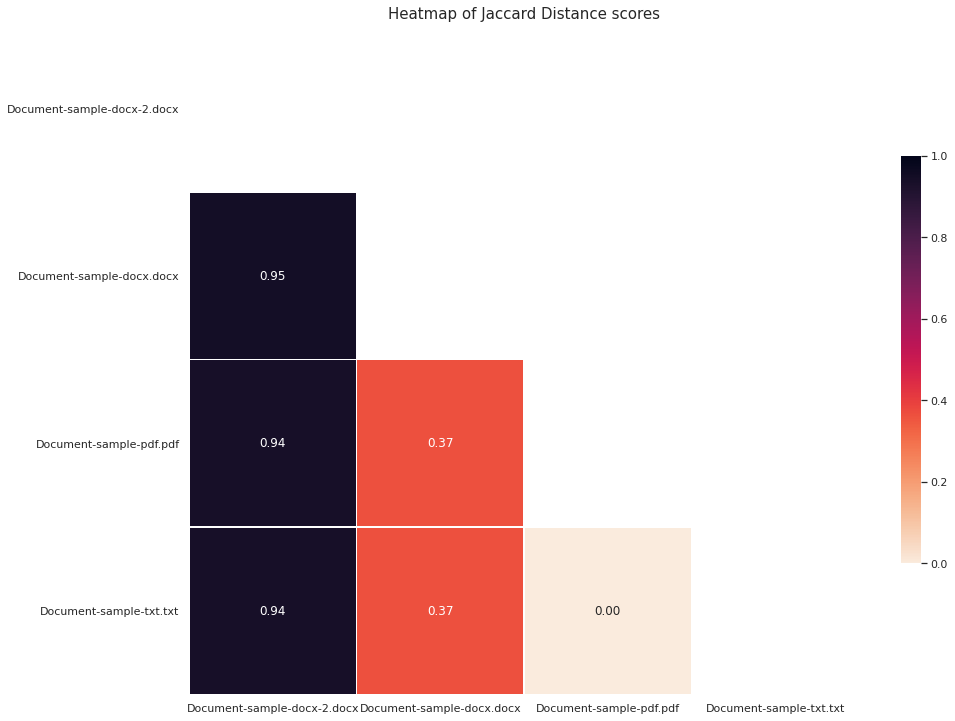

In [2]:
from datetime import datetime
from os import scandir
import textract
from cleantext import clean as txtclean
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from nltk.corpus import stopwords
import sys
import warnings
warnings.filterwarnings("ignore")

def convert_date(timestamp):
    d = datetime.utcfromtimestamp(timestamp)
    formated_date = d.strftime('%d %b %Y')
    return formated_date

def get_files_and_texts(basepath, texts):
    dir_entries = scandir(basepath)
    for index, entry in enumerate(dir_entries):
        text = ""
        if entry.is_file():
            info = entry.stat()
            text = textract.process(entry.path).decode('utf-8')
            text = txtclean(text,
                        all=False,
                        extra_spaces=True,
                        stemming=False,
                        stopwords=True,
                        lowercase=False,
                        numbers=False,
                        punct=True,
                        stp_lang='english'
                    )
        if sys.argv[2] == 'alias':
            texts.append({'filename':"Document-{}".format(index+1), 'text':text})
        else:
            texts.append({'filename':"Document-{}".format(entry.name), 'text':text})
    return dir_entries, texts

def plot_heatmap(df_hm, xlabels, ylabels, metric):
    sns.set(style="white")
    
    f, ax = plt.subplots(figsize=(15, 15))
    
    cmap_similarity = sns.cm.rocket
    cmap_distance = sns.cm.rocket_r
    
    mask = np.zeros_like(df_hm, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    if metric == 'Cosine Similarity':
        sns.heatmap(df_hm, mask=mask, cmap=cmap_similarity, center=0.5, 
                xticklabels=xlabels, yticklabels=ylabels,
                square=True, linewidths=.5, fmt='.2f', 
                annot=True, cbar_kws={"shrink": .5}, vmax=1)
    else:
        sns.heatmap(df_hm, mask=mask, cmap=cmap_distance, center=0.5, 
        xticklabels=xlabels, yticklabels=ylabels,
        square=True, linewidths=.5, fmt='.2f', 
        annot=True, cbar_kws={"shrink": .5}, vmax=1)

    ax.set_title("Heatmap of {} scores".format(metric)).set_fontsize(15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.show()

try:
    texts = []
    folder_name = sys.argv[1]
    basepath = 'documents/sample-folder'
    custom_stopwords = frozenset(stopwords.words('indonesian'))
    dir_entries, texts = get_files_and_texts(basepath, texts)

    text_list = [item['text'] for item in texts]

    count_vectorizer = CountVectorizer(stop_words=custom_stopwords)
    sparse_matrix = count_vectorizer.fit_transform([item['text'] for item in texts])

    doc_term_matrix = sparse_matrix.todense()
    df = pd.DataFrame(doc_term_matrix, 
                    columns=count_vectorizer.get_feature_names(), 
                    index=[item['filename'] for item in texts])

    cosine_results = cosine_similarity(df, df)
    ids = [item['filename'] for item in texts]
    print('>> Cosine Similarity:')
    for i in range(len(cosine_results)):
        temp_cosine_results = list(cosine_results[i])
        pop_items = temp_cosine_results.pop(i)
        print('{:.2f}% >> max pairwise similarity | {:.2f}% >> collectively similar | {}'.format(100*sorted(temp_cosine_results,reverse=True)[0],100*statistics.mean(temp_cosine_results),ids[i]))
        
    correlation_results = pairwise_distances(df.values, metric='correlation')
    ids = [item['filename'] for item in texts]
    print('>> Correlation Similarity:')
    for i in range(len(correlation_results)):
        temp_correlation_results = list(correlation_results[i])
        pop_items = temp_correlation_results.pop(i)
        print('{:.2f}% >> max pairwise similarity | {:.2f}% >> collectively similar | {}'.format(100*(1-sorted(temp_correlation_results,reverse=False)[0]),100*(1-statistics.mean(temp_correlation_results)),ids[i]))
        
    jaccard_results = pairwise_distances(df.values, metric='jaccard')
    ids = [item['filename'] for item in texts]
    print('>> Jaccard Similarity:')
    for i in range(len(jaccard_results)):
        temp_jaccard_results = list(jaccard_results[i])
        pop_items = temp_jaccard_results.pop(i)
        print('{:.2f}% >> max pairwise similarity | {:.2f}% >> collectively similar | {}'.format(100*(1-sorted(temp_jaccard_results,reverse=False)[0]),100*(1-statistics.mean(temp_jaccard_results)),ids[i]))

    plot_heatmap(cosine_results, ids, ids, "Cosine Similarity")
    plot_heatmap(correlation_results, ids, ids, "Correlation Distance")
    plot_heatmap(jaccard_results, ids, ids, "Jaccard Distance")
except Exception as e:
    print(e)